# Solving Eigenvalue Problems with FFNN Models

In this notebook, a FFNN model is employed within the TensorFlow framework to learn the solution to the nonlinear, coupled ODE, presented by Yi et. al in the article from [Computers and Mathematics with Applications 47, 1155 (2004)](https://www.sciencedirect.com/science/article/pii/S0898122104901101), describing the state of a CTRNN model. Given a real symmetric matrix $A$ in the source term, the temporal dynamic described by this ODE has convergence properties to the largest eigenvalue. Simply replacing $A$ with $-A$ yield the smallest eigenvalue. The article also states that the network should converge to a different eigenvalue if the initial vector, $\mathbf{x}_0$, is orthogonal to the eigenvector corresponding to the largest eigenvalue.

The aim is to design a FFNN model suitable for solving this ODE, and check if it succeed in computing both the largest and smallest eigenvalue for some benchmark $3\times 3$ and $6\times 6$ real symmetric matrices. We will also check whether the network converges to a different eigenvalue than the largest if $\mathbf{x}_0$ is chosen to be orthogonal to the eigenvector corresponding to the largest eigenvalue. 

In order to assess the FFNN model, we will compare the result with those from Euler's method for solving the same ODE and Numpy's ``linalg.eig`` which directly computes the eigenvalues of the matrix $A$. 

Unfortunately, we found tensorflow objects (such as tensorflow functions) hard to reuse. There is therefore much repetitive code in the code cells below. This notebook is organized such that each code cell have all the necessary code, except imports, to solve a particular problem. To better distinguish what problem a particular code cell solves, we have added headers that explains the problem at hand. 

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Import code from src
sys.path.insert(0, '../src/')
from tools import fig_path

tf.keras.backend.set_floatx("float64")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

## Benchmark Problem 1: Largest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 1.277072134699062
Step: 100, Loss: 0.13565214997579453
Step: 200, Loss: 0.04199647585450174
Step: 300, Loss: 0.02320971415035938
Step: 400, Loss: 0.013092356825677515
Step: 500, Loss: 0.010640557392493376
Step: 600, Loss: 0.003952909408189469
Step: 700, Loss: 0.0019266407662336847
Step: 800, Loss: 0.002933022277414668
Step: 900, Loss: 0.005472781084249442
Step: 1000, Loss: 0.0003366347577388949
Step: 1100, Loss: 0.00016657266246487848
Step: 1200, Loss: 0.0005815261914622914
Step: 1300, Loss: 0.0028027506129634995
Step: 1400, Loss: 8.744178286420305e-05
Step: 1500, Loss: 9.128313022980171e-05
Step: 1600, Loss: 0.000615254294458216
Step: 1700, Loss: 0.00034588117090866583
Step: 1800, Loss: 6.694982150420078e-05
Step: 1900, Loss: 0.0002826787527766807
Step: 2000, Loss: 2.5482032466376834e-05

A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [1 0 0]
Eigvals Numpy: [-1.  8. -1.]
Max Eigval Numpy 8.0
Eigvec Numpy: [0.66666667 0.33333333 0.66666667]
Final Rayleigh Quotient Euler 7

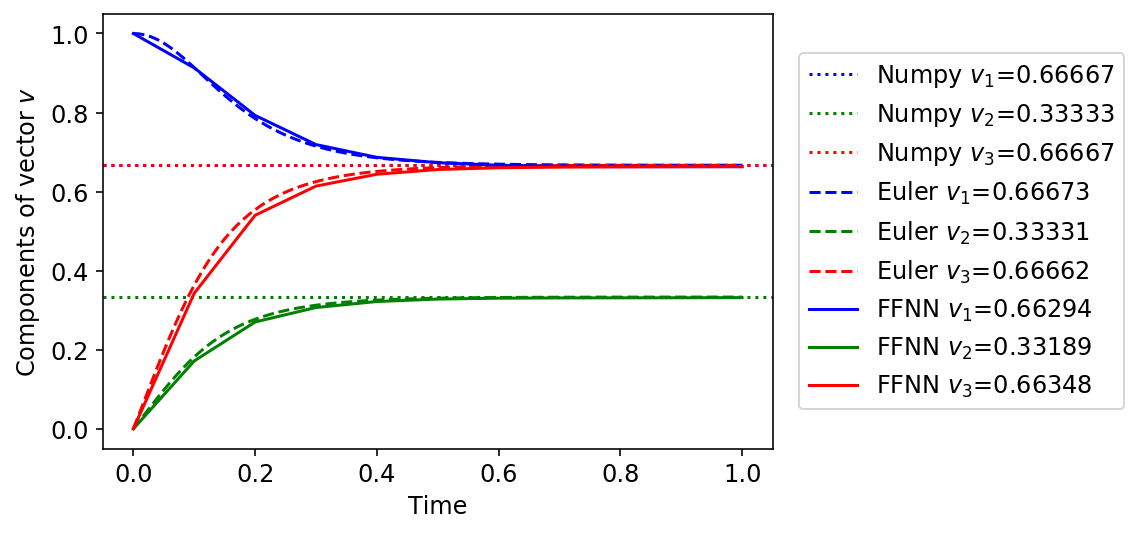

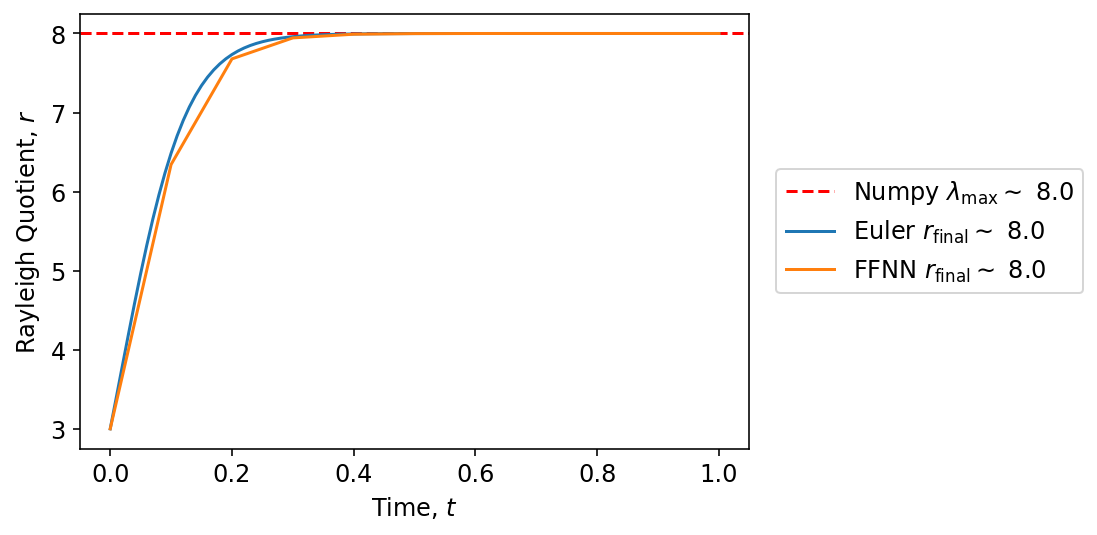

In [27]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Eigvec Numpy:', w[:,1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t_tf, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(t_tf, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(t_tf, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector $v$')
ax0.set_xlabel('Time')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun1.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun1.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 2: Smallest Eigenvalue of a 3x3 Matrix 

Step: 1, Loss: 1.4253581597021954
Step: 100, Loss: 0.21476604767755
Step: 200, Loss: 0.039775624865388534
Step: 300, Loss: 0.01585795719915563
Step: 400, Loss: 0.00975734490295043
Step: 500, Loss: 0.005421397775629549
Step: 600, Loss: 0.003581666273218884
Step: 700, Loss: 0.0022619801387375273
Step: 800, Loss: 0.0014662112555196025
Step: 900, Loss: 0.0005523088290164168
Step: 1000, Loss: 0.0002525744582020952
Step: 1100, Loss: 0.0012957323769615516
Step: 1200, Loss: 0.0003515574608535466
Step: 1300, Loss: 0.002101753722286153
Step: 1400, Loss: 0.0027004262994703818
Step: 1500, Loss: 0.0015220830552606828
Step: 1600, Loss: 0.00047903163081298354
Step: 1700, Loss: 0.0001020243892438309
Step: 1800, Loss: 3.319449977666575e-05
Step: 1900, Loss: 2.294216495952325e-05
Step: 2000, Loss: 1.6330124675615532e-05

A = [[-3. -2. -4.]
 [-2. -0. -2.]
 [-4. -2. -3.]]
x0 = [1 0 0]
Eigvals Numpy: [ 1. -8.  1.]
Max Eigval Numpy 1.0000000000000009
Eigvec Numpy: [-0.66666667 -0.33333333 -0.66666667]
Final

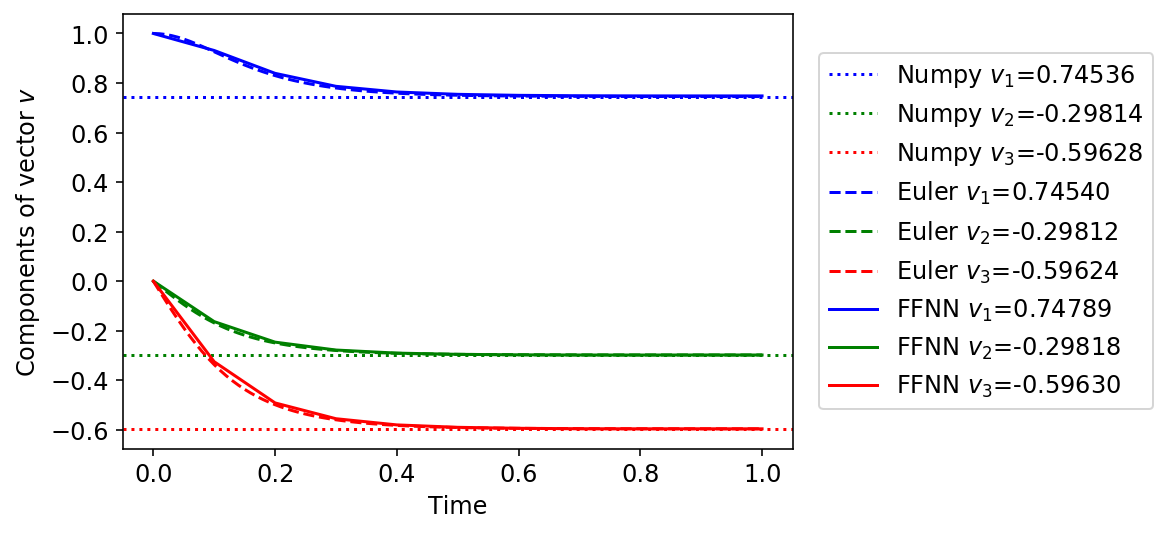

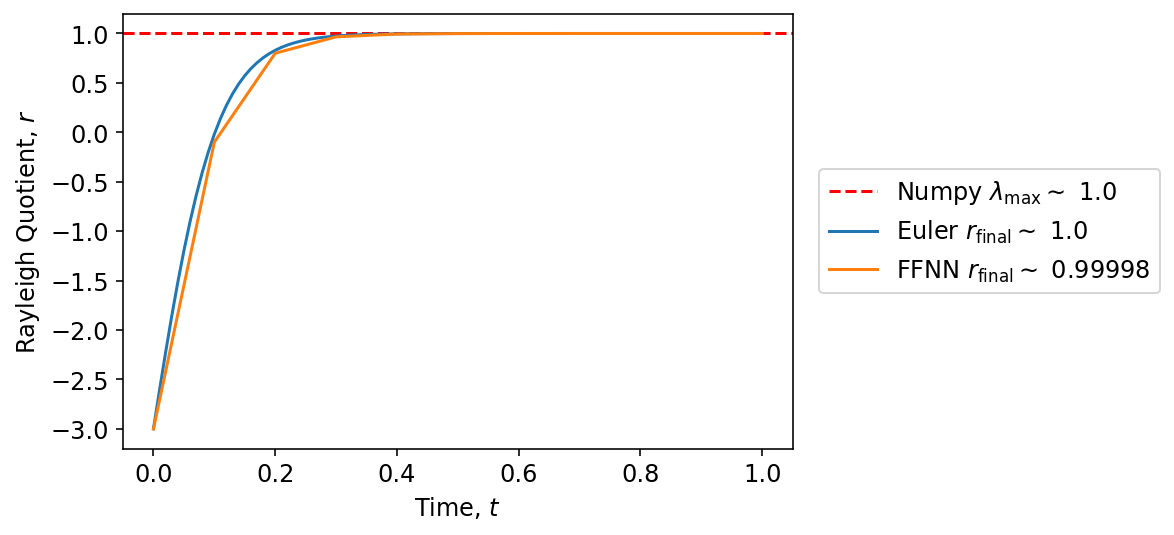

In [29]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
A = -A
x0 = np.array([1, 0, 0])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Eigvec Numpy:', w[:,1])
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, np.argmax(v)], color='b', ls=':', label=f'Numpy $v_1$={w[0, np.argmax(v)]:.5f}')
ax0.axhline(w[1, np.argmax(v)], color='g', ls=':', label=f'Numpy $v_2$={w[1, np.argmax(v)]:.5f}')
ax0.axhline(w[2, np.argmax(v)], color='r', ls=':', label=f'Numpy $v_3$={w[2, np.argmax(v)]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t_tf, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(t_tf, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(t_tf, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector $v$')
ax0.set_xlabel('Time')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun2.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun2.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 3: Degenerated eigenvalues effect on steady-state vector with ill-informed initial vector

Step: 1, Loss: 0.5020743783213895
Step: 100, Loss: 0.05570003402600076
Step: 200, Loss: 0.014996362445788919
Step: 300, Loss: 0.001958183567549199
Step: 400, Loss: 0.0006890584129499873
Step: 500, Loss: 0.00024255178009082066
Step: 600, Loss: 0.00012510260577630586
Step: 700, Loss: 0.00010600741908768806
Step: 800, Loss: 5.73460726145731e-05
Step: 900, Loss: 0.0041042697888808745
Step: 1000, Loss: 3.291593793011478e-05
Step: 1100, Loss: 2.4512148716230752e-05
Step: 1200, Loss: 0.00013231983855402764
Step: 1300, Loss: 1.6910530115474872e-05
Step: 1400, Loss: 0.00014488095258865337
Step: 1500, Loss: 1.2865333233497455e-05
Step: 1600, Loss: 2.7769526988509872e-05
Step: 1700, Loss: 2.6772300885015847e-05
Step: 1800, Loss: 9.282603904650132e-06
Step: 1900, Loss: 1.0660608870317864e-05
Step: 2000, Loss: 9.798526187446212e-06

A = [[-3. -2. -4.]
 [-2. -0. -2.]
 [-4. -2. -3.]]
x0 = [-0.6 -0.6  0.6]
Eigvals Numpy: [ 1. -8.  1.]
Max Eigval Numpy 1.0000000000000009
Eigvec Numpy: [-0.66666667 -0.3

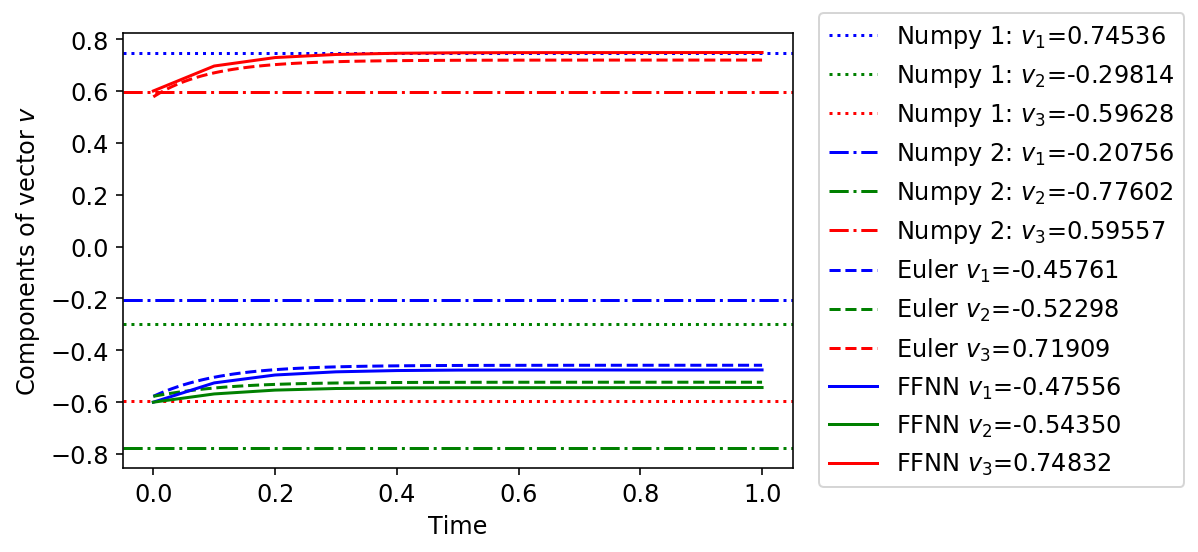

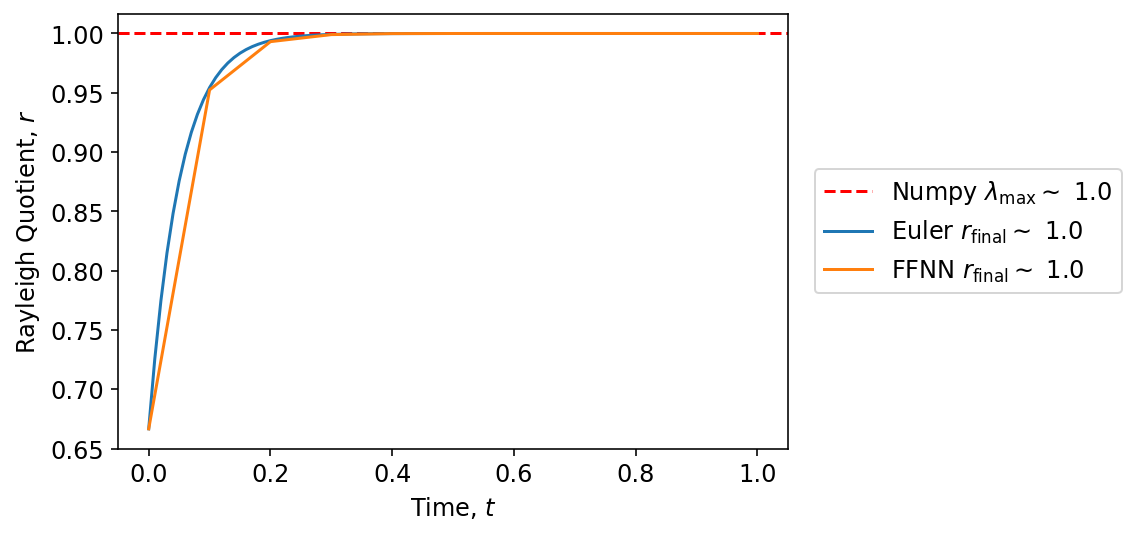

In [32]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
A = -A
x0 = np.array([-0.6, -0.6, 0.6])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.max(v) - eig_euler[-1]) / np.max(v)))
print('Percent Error FFNN', 100 * np.abs((np.max(v) - eig_nn.numpy()[-1]) / np.max(v)))

# Plot components of computed steady-state vector
fig0, ax0 = plt.subplots()
ax0.axhline(w[0, 0], color='b', ls=':', label=f'Numpy 1: $v_1$={w[0, 0]:.5f}')
ax0.axhline(w[1, 0], color='g', ls=':', label=f'Numpy 1: $v_2$={w[1, 0]:.5f}')
ax0.axhline(w[2, 0], color='r', ls=':', label=f'Numpy 1: $v_3$={w[2, 0]:.5f}')
ax0.axhline(w[0, 2], color='b', ls='-.', label=f'Numpy 2: $v_1$={w[0, 2]:.5f}')
ax0.axhline(w[1, 2], color='g', ls='-.', label=f'Numpy 2: $v_2$={w[1, 2]:.5f}')
ax0.axhline(w[2, 2], color='r', ls='-.', label=f'Numpy 2: $v_3$={w[2, 2]:.5f}')
ax0.plot(t, x_euler[:, 0], color='b', ls='--', label=f'Euler $v_1$={x_euler[-1, 0]:.5f}')
ax0.plot(t, x_euler[:, 1], color='g', ls='--', label=f'Euler $v_2$={x_euler[-1, 1]:.5f}')
ax0.plot(t, x_euler[:, 2], color='r', ls='--', label=f'Euler $v_3$={x_euler[-1, 2]:.5f}')
ax0.plot(t_tf, g[:, 0], color='b', label=f'FFNN $v_1$={g[-1, 0]:.5f}')
ax0.plot(t_tf, g[:, 1], color='g', label=f'FFNN $v_2$={g[-1, 1]:.5f}')
ax0.plot(t_tf, g[:, 2], color='r', label=f'FFNN $v_3$={g[-1, 2]:.5f}')
ax0.set_ylabel('Components of vector $v$')
ax0.set_xlabel('Time')
ax0.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), fancybox=True, borderaxespad=0, ncol=1)
fig0.savefig(fig_path("eigvec_comp_benchrun3.pdf"), bbox_inches='tight')

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun3.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 4:  Initial Vector Orthogonal to Eigenvector Corresponding to Largest Eigenvalue

Step: 1, Loss: 0.4065356972162814
Step: 100, Loss: 3.984458741550852e-06
Step: 200, Loss: 9.862038410239173e-07
Step: 300, Loss: 4.5005205057392714e-07
Step: 400, Loss: 1.800971665527438e-07
Step: 500, Loss: 6.956829267135706e-08
Step: 600, Loss: 0.00020760119631985614
Step: 700, Loss: 8.173055082425726e-08
Step: 800, Loss: 4.615673666037117e-08
Step: 900, Loss: 2.8249531173105524e-08
Step: 1000, Loss: 0.0013613934114049767
Step: 1100, Loss: 1.0960166023542054e-07
Step: 1200, Loss: 4.795601627110615e-08
Step: 1300, Loss: 0.008800505125420367
Step: 1400, Loss: 3.5503856925352043e-07
Step: 1500, Loss: 6.826718304473978e-08
Step: 1600, Loss: 2.472952604812747e-06
Step: 1700, Loss: 1.092179415138267e-06
Step: 1800, Loss: 4.160730933576323e-06
Step: 1900, Loss: 1.317645740921033e-06
Step: 2000, Loss: 0.0025307756620390966

A = [[3. 2. 4.]
 [2. 0. 2.]
 [4. 2. 3.]]
x0 = [ 1  0 -1]
Eigvals Numpy: [-1.  8. -1.]
Final Rayleigh Quotient Euler -0.9999999999999998
Final Rayleigh Quotient FFNN -0.99

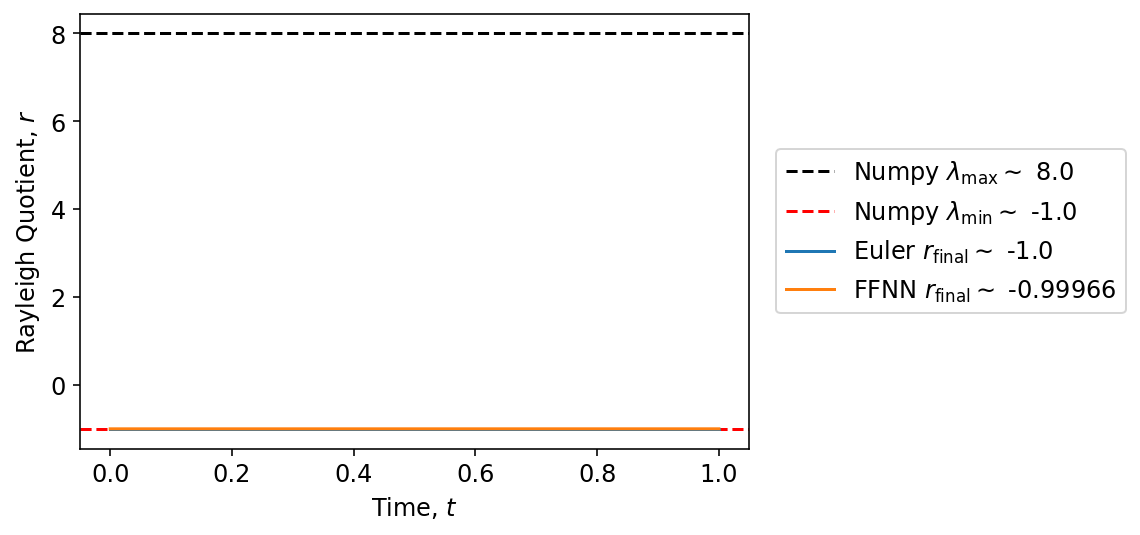

In [47]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t)) 

@tf.function
def rhs(model, A, x0, t):
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @ x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)

# Define problem
tf.random.set_seed(42)
n = 3    # Dimension
T = 1    # Final time

# Problem formulation for Euler
N = 101   # number of time points
A = np.array([[3., 2., 4.], [2., 0., 2.], [4., 2., 3.]])
x0 = np.array([1, 0, -1])
t = np.linspace(0, T, N)

# Problem formulation for tensorflow
Nt = 11   # number of time points
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])

# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.min(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.min(v) - eig_nn.numpy()[-1]))
print('Percent Error Euler', 100 * np.abs((np.min(v) - eig_euler[-1]) / np.min(v)))
print('Percent Error FFNN', 100 * np.abs((np.min(v) - eig_nn.numpy()[-1]) / np.min(v)))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='k', ls='--')
ax.axhline(np.min(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy1 = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_numpy2 = "Numpy $\\lambda_{\\mathrm{min}} \\sim$ " + \
    str(round(np.min(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy1, lgd_numpy2, lgd_euler, lgd_nn], loc='center left', bbox_to_anchor=(1.04, 0.5),
           fancybox=True, borderaxespad=0, ncol=1)
fig.savefig(fig_path("eigval_benchrun4.pdf"), bbox_inches='tight')
plt.show()

## Benchmark Problem 5: 6x6 matrix and the effect of increased time and time points

### a-run: T=10, N=51 (Euler), Nt=5 (FFNN)

Step: 1, Loss: 1.4100977655620697
Step: 100, Loss: 0.0009146978020291095
Step: 200, Loss: 0.000720641277593243
Step: 300, Loss: 0.0005231387825440708
Step: 400, Loss: 0.00034481363099184007
Step: 500, Loss: 0.00023645540542932948
Step: 600, Loss: 0.0001855403769121855
Step: 700, Loss: 0.0001566804443635481
Step: 800, Loss: 0.00013473435008810566
Step: 900, Loss: 0.00011513842976665521
Step: 1000, Loss: 9.675275942217971e-05
Step: 1100, Loss: 7.939889593313554e-05
Step: 1200, Loss: 6.337570335587367e-05
Step: 1300, Loss: 4.952277743222574e-05
Step: 1400, Loss: 3.854699670074273e-05
Step: 1500, Loss: 3.0291153111707275e-05
Step: 1600, Loss: 2.426587854776209e-05
Step: 1700, Loss: 1.9992653244306095e-05
Step: 1800, Loss: 1.7021378983052638e-05
Step: 1900, Loss: 1.4947643025365086e-05
Step: 2000, Loss: 1.3446619520203505e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254

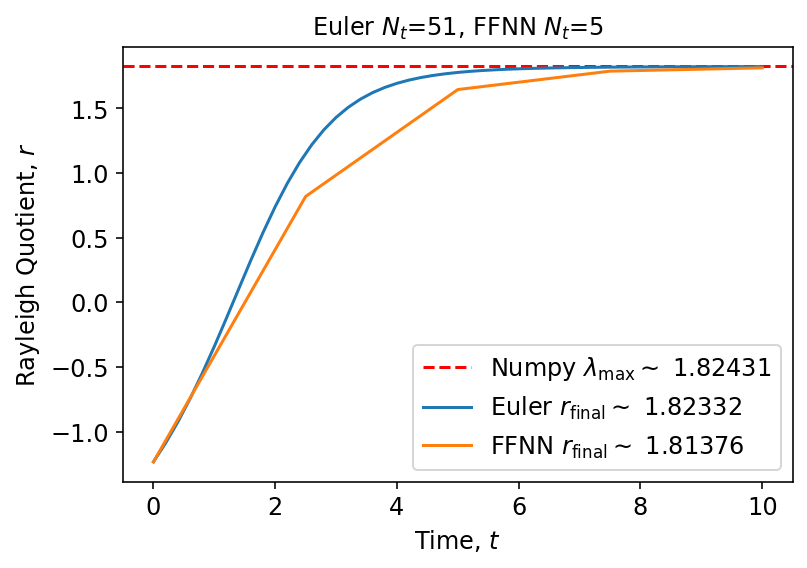

In [57]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 51   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)

# Problem formulation for tensorflow
Nt = 5   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66a.pdf"), bbox_inches='tight')
plt.show()

### b-run: T=10, N=101 (Euler), Nt=11 (FFNN)

Step: 1, Loss: 1.3945865218491946
Step: 100, Loss: 0.0007279225967363037
Step: 200, Loss: 0.0006284139732119902
Step: 300, Loss: 0.00054103254381269
Step: 400, Loss: 0.00045108669380389667
Step: 500, Loss: 0.0003629665311132521
Step: 600, Loss: 0.00028581695419156044
Step: 700, Loss: 0.00023247953812181933
Step: 800, Loss: 0.00019877438469185165
Step: 900, Loss: 0.0001728953144141392
Step: 1000, Loss: 0.00014914115256009348
Step: 1100, Loss: 0.0001260046484666898
Step: 1200, Loss: 0.0001045494392697063
Step: 1300, Loss: 8.668440256243472e-05
Step: 1400, Loss: 7.258627843845206e-05
Step: 1500, Loss: 6.182077960997811e-05
Step: 1600, Loss: 5.3801137961530216e-05
Step: 1700, Loss: 4.782215184799131e-05
Step: 1800, Loss: 4.321288778421288e-05
Step: 1900, Loss: 3.944300936587104e-05
Step: 2000, Loss: 3.615440645401801e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1

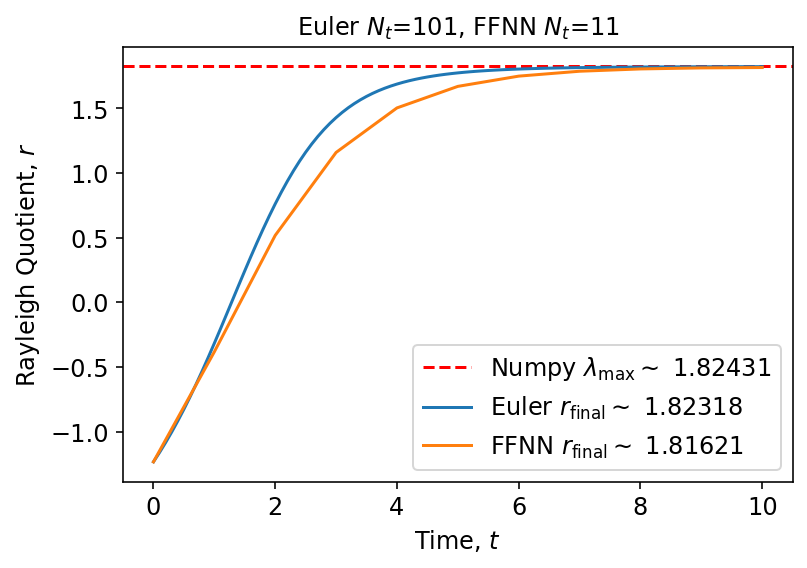

In [58]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 101   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66b.pdf"), bbox_inches='tight')
plt.show()

### c-run: T=10, N=501 (Euler), Nt=51 (FFNN)

Step: 1, Loss: 1.4005256537929422
Step: 100, Loss: 0.0005616389093999424
Step: 200, Loss: 0.0004763383530573217
Step: 300, Loss: 0.00043704020915076103
Step: 400, Loss: 0.0003981566855902194
Step: 500, Loss: 0.00035713355583298254
Step: 600, Loss: 0.00031491654768714807
Step: 700, Loss: 0.00027281270648729097
Step: 800, Loss: 0.0002327817047160239
Step: 900, Loss: 0.00019770358962567383
Step: 1000, Loss: 0.00016942740181847665
Step: 1100, Loss: 0.0001462354222399188
Step: 1200, Loss: 0.00012558400529828144
Step: 1300, Loss: 0.0001072452770117891
Step: 1400, Loss: 9.193395007410954e-05
Step: 1500, Loss: 7.933747929572434e-05
Step: 1600, Loss: 6.903448454223118e-05
Step: 1700, Loss: 6.06894886833563e-05
Step: 1800, Loss: 5.3930240861257995e-05
Step: 1900, Loss: 4.838424173420839e-05
Step: 2000, Loss: 4.373366843776688e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254 

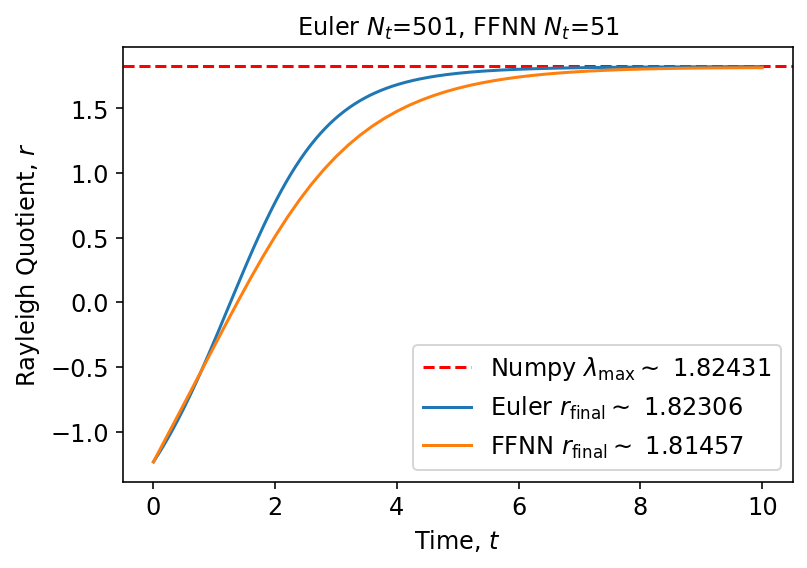

In [59]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6    # Dimension
T = 10    # Final time
N = 501   # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)

# Problem formulation for tensorflow
Nt = 51   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66c.pdf"), bbox_inches='tight')
plt.show()

### d-run: T=10, N=1001 (Euler), Nt=101 (FFNN)

Step: 1, Loss: 1.4020012502417658
Step: 100, Loss: 0.0005384867238143791
Step: 200, Loss: 0.0004544524497659284
Step: 300, Loss: 0.0004183537415765089
Step: 400, Loss: 0.0003843745856943542
Step: 500, Loss: 0.0003483405480740395
Step: 600, Loss: 0.00031079144435546474
Step: 700, Loss: 0.0002726920631333837
Step: 800, Loss: 0.0002354183568428442
Step: 900, Loss: 0.00020105979305659523
Step: 1000, Loss: 0.00017192972965989896
Step: 1100, Loss: 0.0001481481882884349
Step: 1200, Loss: 0.0001276467983048042
Step: 1300, Loss: 0.00010950019292644108
Step: 1400, Loss: 9.423820117017499e-05
Step: 1500, Loss: 8.16555346411531e-05
Step: 1600, Loss: 7.126067364258315e-05
Step: 1700, Loss: 6.27174862757655e-05
Step: 1800, Loss: 5.570224619867869e-05
Step: 1900, Loss: 4.98864191007808e-05
Step: 2000, Loss: 4.4981212496910986e-05

A = [[ 0.49671415  0.72047426  0.4448254   0.30750289 -0.38926805 -0.41792178]
 [ 0.72047426  0.76743473 -1.19137732 -0.43487183 -0.17624755  0.69327422]
 [ 0.4448254  -1.1

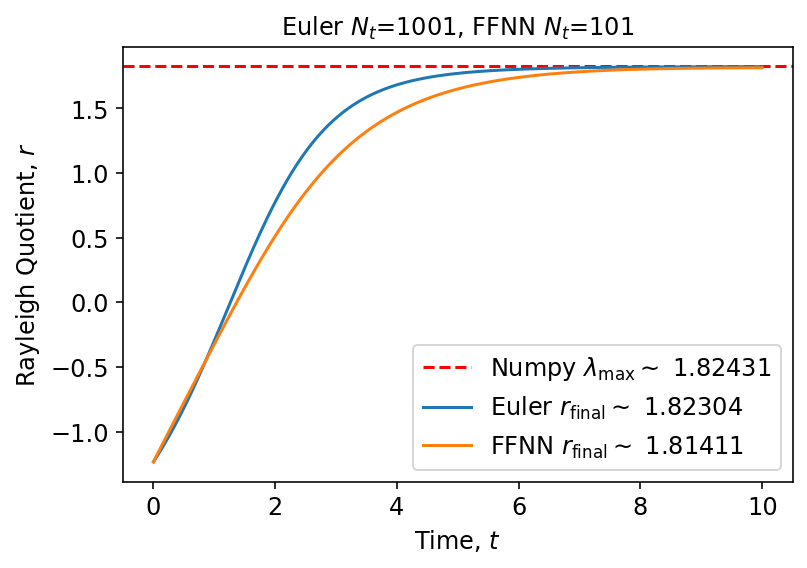

In [60]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(42)
tf.random.set_seed(42)
n = 6     # Dimension
T = 10    # Final time
N = 1001  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)

# Problem formulation for tensorflow
Nt = 101   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
fig.savefig(fig_path("eigval_run66d.pdf"), bbox_inches='tight')
plt.show()

## Final test: see if observations hold for another random 6x6 matrix

Step: 1, Loss: 0.444223887703279
Step: 100, Loss: 0.0002807029353483686
Step: 200, Loss: 0.0001791264052518343
Step: 300, Loss: 9.854576128043662e-05
Step: 400, Loss: 5.246197105886002e-05
Step: 500, Loss: 3.399153079603944e-05
Step: 600, Loss: 2.5043777616877825e-05
Step: 700, Loss: 1.9280852300755405e-05
Step: 800, Loss: 1.533162113494368e-05
Step: 900, Loss: 1.2649320037991854e-05
Step: 1000, Loss: 1.0842360853161099e-05
Step: 1100, Loss: 9.588608911665805e-06
Step: 1200, Loss: 8.654868296702011e-06
Step: 1300, Loss: 7.89698239598658e-06
Step: 1400, Loss: 7.2365080216453445e-06
Step: 1500, Loss: 6.634460577005802e-06
Step: 1600, Loss: 6.072390381328378e-06
Step: 1700, Loss: 5.541528405164006e-06
Step: 1800, Loss: 5.037451109346528e-06
Step: 1900, Loss: 4.557743759442551e-06
Step: 2000, Loss: 4.101050857541676e-06

A = [[ 0.27071232  0.02441395  0.26005195 -0.28373944 -0.88360192  0.01237785]
 [ 0.02441395 -0.78985181  0.62996357  0.12044088  1.19613654  0.37653447]
 [ 0.26005195  0.

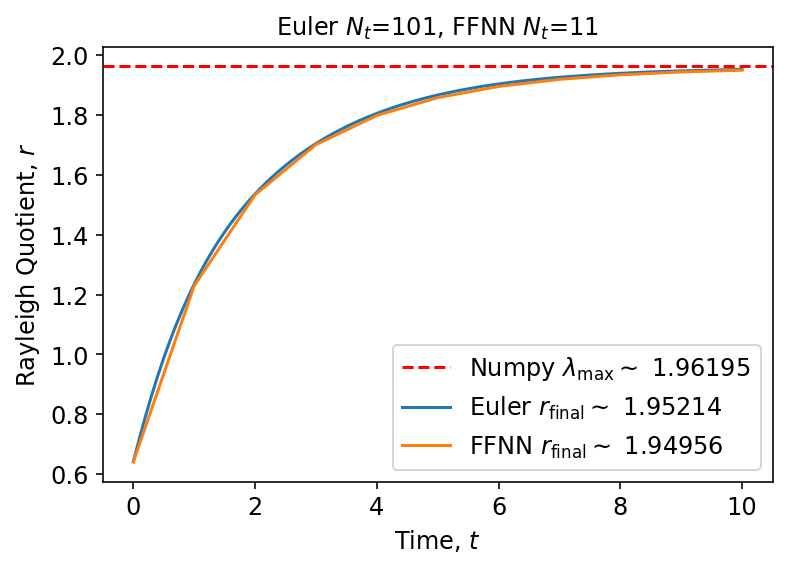

In [63]:
# Define trial solution, ODE rhs, loss function, and gradient method
@tf.function
def trial_solution(model, x0, t):
    return tf.einsum('i...,j->ij', tf.exp(-t), x0) + tf.einsum('i...,ij->ij', (1-tf.exp(-t)), model(t))   

@tf.function
def rhs(model, A, x0, t):
    #A = tf.cast(A, tf.float32)
    g = trial_solution(model, x0, t)
    return tf.einsum('ij,ij,kl,il->ik', g, g, A, g) - tf.einsum('ij,jk,ik,il->il', g, A, g, g)

@tf.function
def loss(model, A, x0, t):
    with tf.GradientTape() as tape:
        tape.watch(t)
        trial = trial_solution(model, x0, t)
    d_trial_dt = tape.batch_jacobian(trial, t)
    d_trial_dt = d_trial_dt[:, :, 0]
    return tf.losses.MSE(d_trial_dt, rhs(model, A, x0, t))
    #return tf.losses.MSE(tf.zeros_like(d_trial_dt), d_trial_dt - rhs(model, A, x0, t))

@tf.function
def grad(model, A, x0, t):
    with tf.GradientTape() as tape:
        loss_value = loss(model, A, x0, t)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Define Rayleigh quotient
def ray_quo(A, x):
    x = x / tf.sqrt(tf.einsum("ij,ij->i", x, x)[:, tf.newaxis])
    return tf.einsum("ij,ij->i", tf.matmul(x, A), x)

# Define Euler's method
def euler_eig(A, x0, T, N):
    dt = T / N
    x = [x0]
    for i in range(N - 1):
        #x.append(x[-1] + dt * (A @ x[-1] - (x[-1].T @ x[-1]) * x[-1]))
        x.append(x[-1] + dt * ((x[-1].T @ x[-1]) * A @
                               x[-1] - (x[-1].T @ A) @ x[-1] * x[-1]))

    x = np.array(x)
    x = x / np.sqrt(np.einsum("ij,ij->i", x, x)[:, np.newaxis])
    eig = np.einsum("ij,ij->i", x @ A, x)

    return x, eig

# Define model
class DNModel(tf.keras.Model):
    def __init__(self, n):
        super(DNModel, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(100, activation=tf.nn.sigmoid)
        self.dense_2 = tf.keras.layers.Dense(50, activation=tf.nn.sigmoid)
        self.dense_3 = tf.keras.layers.Dense(25, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(n, name="output")

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.out(x)


# Define problem
np.random.seed(41)
tf.random.set_seed(41)
n = 6     # Dimension
T = 10    # Final time
N = 101  # number of time points (Euler)
t = np.linspace(0, T, N)

A = np.random.normal(0, 1, (n, n))
A = -A
A = (A.T + A) * 0.5    
x0 = np.random.rand(n)
x0 = x0 / np.linalg.norm(x0, ord=1)

# Problem formulation for tensorflow
Nt = 11   # number of time points (FFNN)
A_tf = tf.convert_to_tensor(A, dtype=tf.float64)
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)
start = tf.constant(0, dtype=tf.float64)
stop = tf.constant(T, dtype=tf.float64)
t_tf = tf.linspace(start, stop, Nt)
t_tf = tf.reshape(t_tf, [-1, 1])


# Initial model and optimizer
model = DNModel(n)
optimizer = tf.keras.optimizers.Adam(0.01)
num_epochs = 2000

for epoch in range(num_epochs):
    cost, gradients = grad(model, A, x0_tf, t_tf)
    optimizer.apply_gradients(  zip(gradients, model.trainable_variables))

    step = optimizer.iterations.numpy()
    if step == 1:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")
    if step % 100 == 0:
        print(f"Step: {step}, " + f"Loss: {tf.math.reduce_mean(cost.numpy())}")

# Call models
x_euler, eig_euler = euler_eig(A, x0, T, N)

g = trial_solution(model, x0_tf, t_tf)
eig_nn = ray_quo(A_tf, g)

# Print results
v, w = np.linalg.eig(A)
print()
print('A =', A)
print('x0 =', x0)
print('Eigvals Numpy:', v)
print('Max Eigval Numpy', np.max(v))
print('Final Rayleigh Quotient Euler', eig_euler[-1])
print('Final Rayleigh Quotient FFNN', eig_nn.numpy()[-1])
print('Absolute Error Euler:', np.abs(np.max(v) - eig_euler[-1]))
print('Absolute Error FFNN:', np.abs(np.max(v) - eig_nn.numpy()[-1]))

# Plot eigenvalues
fig, ax = plt.subplots()
ax.axhline(np.max(v), color='red', ls='--')
ax.plot(t, eig_euler)
ax.plot(t_tf, eig_nn)
ax.set_title(f"Euler $N_t$={N}, FFNN $N_t$={Nt}")
ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rayleigh Quotient, $r$')
lgd_numpy = "Numpy $\\lambda_{\\mathrm{max}} \\sim$ " + \
    str(round(np.max(v), 5))
lgd_euler = "Euler $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_euler[-1], 5))
lgd_nn = "FFNN $r_{\\mathrm{final}} \\sim$ " + \
    str(round(eig_nn.numpy()[-1], 5))
plt.legend([lgd_numpy, lgd_euler, lgd_nn], loc='best')
#fig.savefig(fig_path("eigval_final1.pdf"), bbox_inches='tight')
plt.show()